In [480]:
#Parameters
g_output_category="Alcohol"
g_transcation_files=["2014.csv","2015.csv","2016.csv","2017.csv","2018.csv"]
g_output_calendar="M" # options are 'M', 'W','D'


In [481]:
from graphviz import Digraph
import pandas as pd
g_Cat_Tree={} # child to parent mapping

allCategories_DF = pd.read_csv("Data/categories.csv")
G = Digraph()

for i in range(0, len(allCategories_DF)):
    G.edge(allCategories_DF["Parent"].iloc[i],allCategories_DF["Child"].iloc[i])
    g_Cat_Tree[allCategories_DF["Child"].iloc[i]]=allCategories_DF["Parent"].iloc[i]

G.render('bin/Categories.gv', view=True) 

'bin/Categories.gv.pdf'

In [477]:
import pandas as pd
import numpy as np

def getLevel(node, target, thisTree):
    level = 0
    try:
        while(node!=target):
            node = thisTree[node]
            level += 1
        return level;
    except:
        return -1
    
def getCategory(storeName, minLen):
    try:
        candidates_DF = g_allLocations.loc[storeName[:minLen]]
        shortListCandidatesSeries = []
        if (type(candidates_DF) is pd.Series):
            shortListCandidatesSeries.append(candidates_DF)
        else:
            for i in range(len(candidates_DF)):
                shortListCandidatesSeries.append(candidates_DF.iloc[i])
        
        for candidate in shortListCandidatesSeries:
            if (storeName.startswith(candidate.loc["Substring"])):
                return candidate["Category"]
        return "Invalid Transaction"
    except:
        return "Invalid Transaction"

# Load the data and some useful global variables
g_allLocations = pd.read_csv("Data/locations.csv")
g_allLocations_min_len = min([len(x) for x in g_allLocations["Substring"] ])
g_allLocations["FirstLetters"] = g_allLocations["Substring"].apply(lambda x:  x[:g_allLocations_min_len])
g_allLocations.set_index("FirstLetters" , inplace=True)

i = 0
for trFile in g_transcation_files:
    newDF = (
        pd.read_csv("Data/"+trFile, 
                     quotechar='"', 
                    header=None, 
                    names=['Date','Store','Payed','Received',"CC"],
                    parse_dates=['Date']
                   )
    )
    if i == 0:
        i += 1
        allTransactions = newDF.copy()
    else:
        allTransactions = allTransactions.append(newDF)
    

allTransactions['Payed']=pd.to_numeric(allTransactions['Payed'])
allTransactions["Category"] = allTransactions["Store"].apply(lambda x: getCategory(x, g_allLocations_min_len))

C:\Users\phill\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


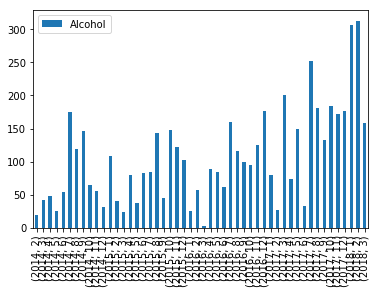

In [479]:
allTransactions["IncludeTransaction"] = allTransactions["Category"].apply(lambda x: getLevel(x,g_output_category, g_Cat_Tree))
relevantTransactions = allTransactions[allTransactions["IncludeTransaction"]>=0]

minDate = min(relevantTransactions["Date"])
maxDate = max(relevantTransactions["Date"])
dateRange = pd.date_range(minDate, maxDate, freq=g_output_calendar)

if g_output_calendar=='W':
    relevantTransactions["Class"] = relevantTransactions["Date"].apply(lambda x: x.isocalendar()[0:2])
    dateRange =[x.isocalendar()[0:2] for x in dateRange]
elif g_output_calendar=='M':
    relevantTransactions["Class"] = relevantTransactions["Date"].apply(lambda x: (x.year,x.month))
    dateRange =[(x.year,x.month) for x in dateRange]
elif g_output_calendar=='Y':
    relevantTransactions["Class"] = relevantTransactions["Date"].apply(lambda x: x.year)
    dateRange =[x.year for x in dateRange]
elif g_output_calendar=='D':
    relevantTransactions["Class"] = relevantTransactions["Date"].apply(lambda x: (x.year,x.month,x.day))
    dateRange =[(x.year,x.month,x.day) for x in dateRange]

toPlotData = relevantTransactions.groupby(["Class", "Category"]).agg({"Payed":sum,"Received":sum}).reset_index().set_index("Category")
toPlotCategories = set(relevantTransactions["Category"])
plottingMaterial=pd.DataFrame(index=dateRange)
for cat in toPlotCategories:
    catDF = toPlotData.loc[cat]
    if (type(catDF) is pd.Series):
        catDF = pd.DataFrame(toPlotData.loc["Fines"]).T
    plottingMaterial[cat] = catDF.set_index("Class")["Payed"]

%matplotlib inline
plottingMaterial.plot(kind='bar', stacked=True)